# Table of contents

### - Import libraries and define functions + Initial setup

### - Quality control and general metrics figures

### - Genes with 2+ RNA isoforms (Unique counts vs Full counts vs Counts)

### - ERCC Figures

### - Percent unique and full-length reads

# Import libraries and define functions + Initial setup

In [1]:
## Import Libraries
import pandas as pd
import numpy as np
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud
import csv
from scipy import stats
import matplotlib.patches as mpatches
import matplotlib.lines as mlines


## Display all rows of pandas dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
'''
function name: get_real_transcript_length

purpose: create dataframe containing exonic transcript length and transcript_id

input: bambu gtf file

output: dataframe with two columns, transcript_id and real_transcript_length
'''

def get_real_transcript_length(annotation):
    
    annotation = parse_df_columns(annotation, is_ref=False)
    
    annotation["real_transcript_length"] = abs(annotation["end"] - annotation["start"])
    
    exon_annotation = annotation.loc[annotation["type"] == "exon"][["transcript_id", "real_transcript_length"]].copy()
    
    df_transcript_length = exon_annotation.groupby("transcript_id").sum()
    
    df_transcript_length.reset_index(inplace=True)
    
    return df_transcript_length    

In [3]:
"""
Convert a hexadecimal color representation to an RGB tuple.

Parameters:
hex_color (str): The color in hexadecimal format. Can start with or without a hash (#).
                  It should be 6 characters long, with each pair representing red, green,
                  and blue color channels respectively.

Returns:
tuple: A tuple containing three integers representing the red, green, and blue color
       values ranging from 0 to 255.
"""

def hex_to_rgb(hex_color: str) -> tuple:

    # Remove the hash at the start if it's there
    hex_color = hex_color.lstrip('#')
    # Convert hex to RGB by taking two characters at a time, and converting to decimal
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

In [4]:
'''
function name: get_real_transcript_length

purpose: create dataframe containing exonic transcript length and transcript_id

input: bambu gtf file

output: dataframe with two columns, transcript_id and real_transcript_length
'''

def get_real_transcript_length(annotation):
    
    annotation = parse_df_columns(annotation, is_ref=False)
    
    annotation["real_transcript_length"] = abs(annotation["end"] - annotation["start"])
    
    exon_annotation = annotation.loc[annotation["type"] == "exon"][["transcript_id", "real_transcript_length"]].copy()
    
    df_transcript_length = exon_annotation.groupby("transcript_id").sum()
    
    df_transcript_length.reset_index(inplace=True)
    
    return df_transcript_length    

In [5]:
'''
name: relative_transcript_abundance

purpose: calculate relative transcript abundance

input: a dataframe with a ref_gene_id column identifying the transcript gene of origin and a cov columns with 
the coverage for the transcripts.

output: the same dataframe with a relative abundance column added
'''



def relative_transcript_abundance(df):
    
    ## Group by gene_id and get total expression for each gene (not counting introns)
    df_sums = df[["gene_id", "total_CPM"]].groupby("gene_id").sum()
    df_sums["total_CPM_gene"] = df_sums["total_CPM"]
    df_sums.drop(columns="total_CPM", inplace=True)
    
    ## Merge dataframe with total gene level CPM with regular transcript level CPM dataframe
    merged_df = pd.merge(df, df_sums, how='inner', on="gene_id")
    
    ## Calculater relative percent abundance for each transcript within its gene
    merged_df["relative_abundance_percent"] = ((merged_df["total_CPM"]/merged_df["total_CPM_gene"]) * 100)
    
    ## Rename total_CPM for transcript column
    merged_df["total_CPM_transcript"] = merged_df["total_CPM"]
    merged_df.drop(columns="total_CPM", inplace=True)


    return merged_df

In [6]:
'''
function name: fix_column_names

purpose: Fixing the column names, making them smaller, informative, and consistent

input: The raw counts dataframe for either genes or transcripts 

output: Same dataframe with improved column names
'''

def fix_column_names(df, is_gene=False):
    
    ## Check if this is a gene counts object
    if is_gene:
        
        ## Get count column names and create list of new column names
        count_columns = df.columns.tolist()
        list_new_names = ["gene_id"]
        
        ## gene_id comes in as index for gene counts data, make it into the first column instead
        df["gene_id"] = df.index
        cols = list(df.columns)
        cols = [cols[-1]] + cols[:-1]
        df = df[cols]
        df.reset_index(inplace=True, drop=True)
    
    ## If it is a transcript dataset
    else:
        ## Set count columns and create list of new names
        count_columns = df.columns[2:].tolist()
        list_new_names = [ "transcript_id", "gene_id"]
    
    ## Fix names one by one and add to list of new names
    for col in count_columns:
        col = col.split("_mapped")[0] + "_counts"
        list_new_names.append(col)
    
    ## Rename columns
    df.columns = list_new_names
    
    return df 

In [7]:
'''
function name: parse_df_columns

purpose: parsing the last aggregate column of the gtf/gff3 into useful columns and cleaning non-relevant columns

input: dataframe containining "raw" gtf/gff

output: dataframe containing gtf with useful columns ["gene_id", "transcript_id", etc...]
'''

def parse_df_columns(df, is_ref=True, is_transcript=False, is_prot=False):

    if is_ref:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)
        
        ## Get gene names
        df["gene_name"] = df["other"].str.split("gene_name \"", expand=True)[1].str.split('\";', expand=True)[0]
        
        ## Get get transcript biotype
        df["gene_biotype"] = df["other"].str.split('gene_biotype "', expand=True)[1].str.split('"', expand=True)[0]
        
        ## If is transcript get transcript id and transcript biotype
        if is_transcript:
            df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]
            df["transcript_biotype"] = df["other"].str.split('transcript_biotype "', expand=True)[1].str.split('"', expand=True)[0]
            
            ## If is prot get protein_id
            if is_prot:
                df["protein_id"] = df["other"].str.split('protein_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["ccds_id"] = df["other"].str.split('ccds_id "', expand=True)[1].str.split('"', expand=True)[0]
                df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)
        

    else:

        ## Get gene ids
        df["gene_id"] = df["other"].str.split('";', expand=True)[0].str.extract("([^ \"]*$)", expand=True)

        ## Get transcript ids
        df["transcript_id"] = df["other"].str.split('transcript_id "', expand=True)[1].str.split('"', expand=True)[0]

        ## Get exon number
        df["exon_number"] = df["other"].str.split('exon_number "', expand=True)[1].str.split('"', expand=True)[0]

        ## Drop "other" column
        df.drop(columns=["other", "dot_1", "dot_2"], inplace=True)

    for col in df.columns:
        df.loc[df[col].isnull(), col] = np.NaN
        

    return df

In [8]:
'''
function name: calculate_cpm

purpose: Calculate CPM for the each sample given

input: Counts dataset

output: Counts dataset with CPM columns as well
'''

def calculate_cpm(df, is_gene=False):

    ## Set count columns if dataframe is gene counts
    if is_gene:
        count_columns = df.columns[1:].tolist()
    
    ## Set count columns if dataframe is transcript counts
    else:
        count_columns = df.columns[2:].tolist()

    ## Loop through counts columns to calculate CPM and add to the dataframe
    for col in count_columns:
        
        df[col] = round(df[col], 2)
        cpm_name = col.replace("_counts", "_CPM")
        df[cpm_name] = round(((df[col]/(df[col].sum())) * 1000000), 2)
    
    return df  

In [9]:
## define ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

## Store QC data from MultiQC into a dataframe and load annotations

In [10]:
## Create dataframe to store MultiQC data

sample_names = ['sample_579_PAG75663', 'sample_1131_PAM44580','sample_1218_PAM43779', 'sample_1304_PAM44487',
 'sample_1271_PAM44815', 'sample_5356_PAM42933', 'sample_1163_PAM44604', 'sample_5295_PAG77944',
 'sample_5292_PAG75292', 'sample_1092_PAM41667', 'sample_1186_PAM43869', 'sample_1291_PAG71816']


status = ["AD", "CT", "AD", "CT", "CT", "CT", "CT", "AD", "AD", "CT", "AD", "AD"]

sex = ["M", "F", "F", "M", "M", "M", "F", "F", "M", "F", "F", "M"]

percent_mito = [13, 7, 23, 6, 9, 9, 8, 23, 13, 10, 8, 18]

total_reads = [156.3, 166.6, 196.7, 119.4, 108.4, 158.9, 104.1, 163.9, 129.7, 163.5, 183.0, 121.2]

pass_reads = [116.6, 120.1, 153.6, 85.9, 86.8, 119.2, 84.8, 122.7, 98.3, 121.2, 129.7, 91.8]

percent_both_primers = [0.817, 0.862, 0.873, 0.813, 0.773, 0.806, 0.746, 0.765, 0.801, 0.826, 0.871, 0.768]

mapped_reads = [73.1, 35.0, 65.7, 32.8, 60.7, 40.1, 70.0, 54.7, 61.4, 52.4, 51.0, 54.2]

mapped_reads_mapq_10 = [47.9, 19.8, 43.0, 20.7, 41.9, 25.6, 45.8, 37.9, 42.2, 32.7, 31.0, 37.8]

n50_mapped = [831, 1120, 699, 1510, 1370, 1560, 1090, 815, 1040, 1010, 802, 954]

median_read_length_mapped = [333, 245, 280, 417, 454, 335, 502, 353, 388, 259, 326, 417]


dictionary_qc = {'sample_name': sample_names, "Sex": sex, "Status": status, 'Mapped pass N50': n50_mapped,
                "Median read length mapped": median_read_length_mapped, "All reads": total_reads, 
                "Pass reads": pass_reads, "Mapped pass reads w/ primers": mapped_reads,
                 "Percent both primers": percent_both_primers, 
                 "Mapped pass reads w/ primers (MAPQ > 10)": mapped_reads_mapq_10, "percent mito": percent_mito}

df_qc_stats = pd.DataFrame(data=dictionary_qc)

df_qc_stats["Pass reads w/ primers"] = df_qc_stats["Pass reads"].copy() * df_qc_stats["Percent both primers"].copy()

In [11]:
## Open original reference
ref = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/extended_annotations.gtf", 
                  header=None, delimiter="\t", low_memory=False, 
                    names=["chr", "source", "type", "start", "end", "dot_1", "strand", "dot_2", "other"], comment="#")

ref_copy = ref.copy()

ref_transcript_length = get_real_transcript_length(ref_copy)

ref = parse_df_columns(ref, is_ref=False)

ref = ref.loc[ref["type"]=="transcript"].copy()

# Total reads plot

In [12]:
## Define dataframes

df_read_numbers = df_qc_stats[["sample_name", "All reads", "Pass reads", "Sex", "Status", 
                               "Pass reads w/ primers", "Mapped pass reads w/ primers", 
                               "Mapped pass reads w/ primers (MAPQ > 10)"]].copy()

df_read_numbers_melt = pd.melt(df_read_numbers, id_vars=['sample_name', "Sex", "Status"], value_vars=["sample_name", "All reads", "Pass reads", 
                               "Pass reads w/ primers", "Mapped pass reads w/ primers", 
                               "Mapped pass reads w/ primers (MAPQ > 10)"], value_name="Million reads")

In [13]:
## Separate Males and Females

df_read_numbers_melt_male = df_read_numbers_melt.loc[df_read_numbers_melt["Sex"] == "M"].copy()

df_read_numbers_melt_female = df_read_numbers_melt.loc[df_read_numbers_melt["Sex"] == "F"].copy()

In [14]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (170*mm, 80*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

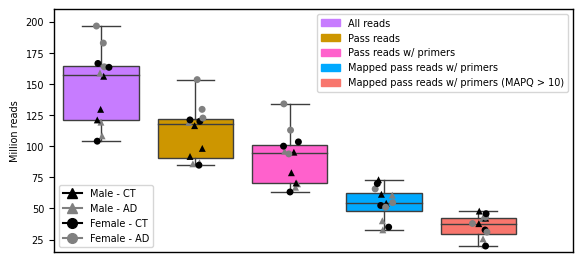

In [15]:
# Your existing code
sns.boxplot(data=df_read_numbers_melt, y="Million reads", x="variable",
           saturation=1, palette=[ggplot2_colors[6], ggplot2_colors[1], ggplot2_colors[7], ggplot2_colors[5], ggplot2_colors[0]],
           showfliers=False, hue="variable", dodge=False, linewidth=1)


male_strip = sns.stripplot(data=df_read_numbers_melt_male,  y="Million reads", x="variable", hue="Status",
             palette=["black", "grey"], size=5, marker="^")

female_strip = sns.stripplot(data=df_read_numbers_melt_female,  y="Million reads", x="variable", hue="Status",
             palette=["black", "grey"], size=5, marker="o")

# Your existing code
plt.ylim([15, 210])
plt.xlabel("")
plt.xticks("")
plt.tick_params(bottom=False)

# Create custom legend handles

reads_list = ["All reads", "Pass reads", "Pass reads w/ primers", "Mapped pass reads w/ primers", 
                "Mapped pass reads w/ primers (MAPQ > 10)"]

colors_list = [ggplot2_colors[6], ggplot2_colors[1], ggplot2_colors[7], ggplot2_colors[5], ggplot2_colors[0]]

# Create custom legend handles
box_legend_handles = [mpatches.Patch(color=colors_list[i], label=reads_list[i]) for i in range(5)]

marker_legend_handles = [mlines.Line2D([0], [0], color='black', marker='^', markersize=7, label='Male - CT'),
                         mlines.Line2D([0], [0], color='grey', marker='^', markersize=7, label='Male - AD'),
                         mlines.Line2D([0], [0], color='black', marker='o', markersize=7, label='Female - CT'),
                         mlines.Line2D([0], [0], color='grey', marker='o', markersize=7, label='Female - AD')]

# Create the legends
legend1 = plt.legend(handles=box_legend_handles, fontsize=7, loc="upper right")
legend2 = plt.legend(handles=marker_legend_handles, fontsize=7, loc="lower left")

# Add the first legend manually to the current Axes
plt.gca().add_artist(legend1)

# Your existing code
plt.savefig('../../figures/paper_figures/supplement/number_of_reads.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

# N50 and median read length plots

In [16]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (80*mm, 80*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

In [17]:
## Created melted dataframe

df_read_length = df_qc_stats[["sample_name", "Sex", "Status", "Mapped pass N50", "Median read length mapped"]].copy()


df_read_length.columns = ["sample_name", "Sex", "Status", "N50", "Median read length"]

df_read_length_melt = pd.melt(df_read_length, id_vars=['sample_name', "Sex", "Status"], 
                              value_vars=["N50", "Median read length"], value_name="Base pairs")

In [18]:
## Separate males and females

df_read_length_melt_male = df_read_length_melt.loc[df_read_length_melt["Sex"] == "M"].copy()

df_read_length_melt_female = df_read_length_melt.loc[df_read_length_melt["Sex"] == "F"].copy()

In [19]:
df_read_length_melt_male.head()

,sample_name,Sex,Status,variable,Base pairs
0,sample_579_PAG75663,M,AD,N50,831
3,sample_1304_PAM44487,M,CT,N50,1510
4,sample_1271_PAM44815,M,CT,N50,1370
5,sample_5356_PAM42933,M,CT,N50,1560
8,sample_5292_PAG75292,M,AD,N50,1040


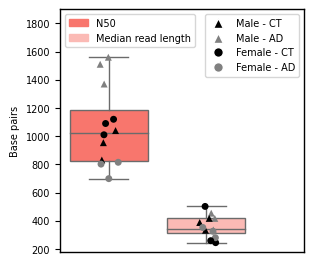

In [20]:
from matplotlib.lines import Line2D
from matplotlib.patches import Patch


ax = sns.boxplot(data=df_read_length_melt, y="Base pairs", x="variable",
           palette=[ggplot2_colors[0], ggplot2_colors[0]], saturation=1,
           showfliers=False, hue="variable", dodge=False, linewidth=1)


male_strip = sns.stripplot(data=df_read_length_melt_male,  y="Base pairs", x="variable",
             size=5, marker="^", palette=["black", "grey"], hue="Status")

female_strip = sns.stripplot(data=df_read_length_melt_female,  y="Base pairs", x="variable",
             size=5, marker="o", palette=["black", "grey"], hue="Status")

i = 0
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    
    if (i==0 or i==1):
        patch.set_facecolor((r, g, b, 1))
        
    else:
        patch.set_facecolor((r, g, b, 0.5))
        
    i += 1
        
## Label list
length_list = ["N50", "Median read length"]
colors = ["#F8766D", "#FBBAB5"]
        
# Creating legend for boxplot
box_legend_handles = [mpatches.Patch(color=colors[i], label=length_list[i]) for i in range(2)]

# Creating legend for stripplots
strip_legend_handles = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='black', markersize=7, label='Male - CT'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='grey', markersize=7, label='Male - AD'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=7, label='Female - CT'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=7, label='Female - AD')
]

# Adding legends to the plot
legend1 = ax.legend(handles=box_legend_handles, loc='upper left')
legend2 = ax.legend(handles=strip_legend_handles, loc='upper right')


# Add the first legend manually to the current Axes
plt.gca().add_artist(legend1)

plt.ylim([180, 1900])
plt.xlabel("")
plt.xticks("")
plt.tick_params(bottom=False)


plt.savefig('../../figures/paper_figures/supplement/read_length.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

# Percent of unique full length and full length reads per sample

In [21]:
## Import counts matrices

df = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_unique = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/uniqueCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_full = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/fullLengthCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

In [22]:
## Fix column names

df = fix_column_names(df, is_gene=False)
df_unique = fix_column_names(df_unique, is_gene=False)
df_full = fix_column_names(df_full, is_gene=False)

In [23]:
## Change column names for full and unique dataframes

count_columns = df.filter(regex='counts').columns
unique_counts_columns = df_unique.filter(regex='counts').columns
full_count_columns = df_full.filter(regex='counts').columns


unique_counts_columns = [s + "_UNIQUE" for s in unique_counts_columns]
full_counts_columns = [s + "_FULL" for s in full_count_columns]

unique_counts_columns.insert(0, "gene_id")
unique_counts_columns.insert(0, "transcript_id")

full_counts_columns.insert(0, "gene_id")
full_counts_columns.insert(0, "transcript_id")

df_unique.columns = unique_counts_columns
df_full.columns = full_counts_columns

In [24]:
## [sample_name, full_counts, unique_counts, full_counts_no_mito, unique_counts_no_mito, full_counts_mito, unique_counts_mito]
percents_list = [[], [], [], [], [], [], [], []]

for col in count_columns:
    col_unique = col + "_UNIQUE"
    col_full = col + "_FULL"
    
    percent_full = (df_full[col_full].sum()/df[col].sum()) * 100
    percent_unique = (df_unique[col_unique].sum()/df[col].sum()) * 100
       
    percents_list[0].append(col)
    percents_list[1].append(percent_full)
    percents_list[2].append(percent_unique)

In [25]:
## Create dataframe to store percent full length and percent unique reads
sample_names_percents = [s[0:-7] for s in percents_list[0]]


dictionary_percents = {'sample_name': sample_names_percents, 'percent_full': percents_list[1], 
                       "percent_unique": percents_list[2]}

df_percent_stats = pd.DataFrame(data=dictionary_percents)

In [26]:
df_qc_stats = df_qc_stats.merge(df_percent_stats, how="inner", on="sample_name")

In [27]:
df_qc_stats["percent_unique"].describe()

count    12.000000
mean     42.404895
std       4.411592
min      35.967790
25%      38.072918
50%      43.464760
75%      44.473143
max      49.502107
Name: percent_unique, dtype: float64

In [28]:
df_percent_full_length = df_qc_stats[["sample_name", "Sex", "Status", "percent_full", "percent_unique"]].copy()

df_percent_full_length.columns = ["sample_name", "Sex", "Status", "Full-length counts", "Unique counts"]

df_percent_full_length_melt = pd.melt(df_percent_full_length, id_vars=['sample_name', "Sex", "Status"], 
                              value_vars=["Full-length counts", "Unique counts"], 
                                      value_name="Percent")


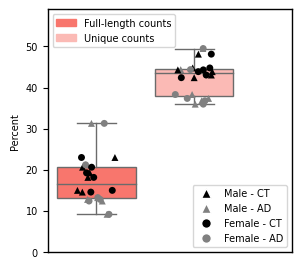

In [29]:
ax = sns.boxplot(data=df_percent_full_length_melt, y="Percent", x="variable",
           palette=[ggplot2_colors[0], ggplot2_colors[0]], saturation=1,
           showfliers=False, hue="variable", dodge=False, linewidth=1)


male_strip = sns.stripplot(data=df_percent_full_length_melt,  y="Percent", x="variable",
             size=5, marker="^", palette=["black", "grey"], hue="Status", jitter=0.2)

female_strip = sns.stripplot(data=df_percent_full_length_melt,  y="Percent", x="variable",
             size=5, marker="o", palette=["black", "grey"], hue="Status", jitter=0.2)

i = 0
for patch in ax.patches:
    r, g, b, a = patch.get_facecolor()
    
    if (i==0 or i==1):
        patch.set_facecolor((r, g, b, 1))
        
    else:
        patch.set_facecolor((r, g, b, 0.5))
    
    i += 1



## Label list
length_list = ["Full-length counts", "Unique counts"]
colors = ["#F8766D", "#FBBAB5"]
        
# Creating legend for boxplot
box_legend_handles = [mpatches.Patch(color=colors[i], label=length_list[i]) for i in range(2)]

# Creating legend for stripplots
strip_legend_handles = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='black', markersize=7, label='Male - CT'),
    Line2D([0], [0], marker='^', color='w', markerfacecolor='grey', markersize=7, label='Male - AD'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=7, label='Female - CT'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='grey', markersize=7, label='Female - AD')
]

# Adding legends to the plot
legend1 = ax.legend(handles=box_legend_handles, loc='upper left')
legend2 = ax.legend(handles=strip_legend_handles, loc='lower right')


# Add the first legend manually to the current Axes
plt.gca().add_artist(legend1)
    
    
plt.ylim([0, 59])
plt.xlabel("")
plt.xticks("")
plt.tick_params(bottom=False)

plt.savefig('../../figures/paper_figures/supplement/percent_full_length.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

# Histogram of CPM expression at gene and transcript level

In [30]:
## Import transcripts
df_transcripts = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt",
        sep="\t", low_memory=False, header=0)


df_transcripts = fix_column_names(df_transcripts, is_gene=False)

In [31]:
df_genes = df_transcripts.groupby("gene_id")[df_transcripts.columns[2:]].sum().reset_index()

In [32]:
df_genes = calculate_cpm(df_genes, is_gene=True)
df_transcripts = calculate_cpm(df_transcripts, is_gene=False)

In [33]:
df_genes["median_CPM"] = df_genes[df_genes.filter(regex='[0-9]_CPM').columns].median(axis=1)
df_transcripts["median_CPM"] = df_transcripts[df_transcripts.filter(regex='[0-9]_CPM').columns].median(axis=1)

In [34]:
## Create lists with number of genes across CPM thresholds
list_cpm_thresh = []
list_num_transcripts_median = []
list_num_genes_median = []

for i in range(0, 1000):
    
    cpm_thresh = i/100
    
    transcript_median_num = df_transcripts.loc[df_transcripts["median_CPM"] >= cpm_thresh].shape[0]
    
    gene_median_num = df_genes.loc[df_genes["median_CPM"] >= cpm_thresh].shape[0]
    
    list_cpm_thresh.append(cpm_thresh)
    
    list_num_transcripts_median.append(transcript_median_num)
    
    list_num_genes_median.append(gene_median_num)

In [35]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (170*mm, 80*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

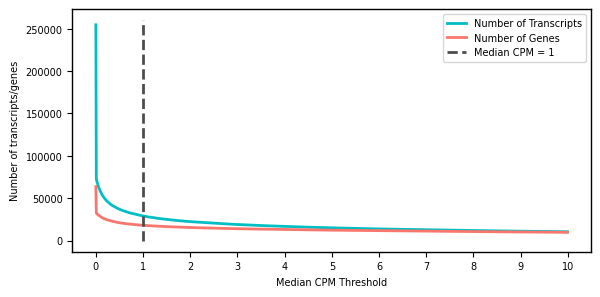

In [36]:
## Make plot showing number of genes and transcripts across CPM thresholds

plt.plot(list_cpm_thresh, list_num_transcripts_median, color=ggplot2_colors[4], 
         label="Number of Transcripts", linewidth=2, alpha=1)

plt.plot(list_cpm_thresh, list_num_genes_median, color=ggplot2_colors[0], 
         label="Number of Genes", linewidth=2, alpha=1)

plt.plot([1, 1], [-100, 260000], color="#4D4D4D", label="Median CPM = 1", linewidth=2, alpha=1, linestyle='dashed')



plt.xticks(np.arange(0, 11, 1))
plt.xlabel('Median CPM Threshold')
plt.ylabel('Number of transcripts/genes')
plt.legend(loc="upper right")

plt.savefig('../../figures/paper_figures/supplement/number_of_genes_and_transcripts_across_cpm_thresh.pdf', dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [37]:
list_num_genes_median[101]

18041

In [38]:
list_num_transcripts_median[101]

28989

In [39]:
df_genes = df_genes.loc[df_genes["median_CPM"] > 0]

In [40]:
## Use ggplot colors
ggplot2_colors = ["#F8766D", "#CD9600", "#7CAE00", "#00BE67", "#00BFC4", "#00A9FF", "#C77CFF", "#FF61CC"]

In [41]:
## Get log total counts
log_median_cpm = np.log10(df_genes["median_CPM"])

In [42]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (80*mm, 80*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

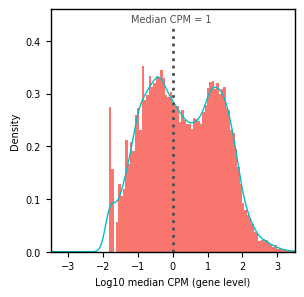

In [43]:
## Create log plot
log_median_cpm.plot(kind = "hist", density = True, bins = 100, color=ggplot2_colors[0], alpha=1) # change density to true, because KDE uses density


log_median_cpm.plot(kind = "kde", color=ggplot2_colors[4], alpha=1, linewidth=1)

plt.xlabel("Log10 median CPM (gene level)", size=7)
plt.ylim([0, 0.46])
plt.xlim([-3.5, 3.5])

plt.axvline(0, ymax=0.94, alpha=1, linestyle = ":", color="#4D4D4D", linewidth=2)
plt.text(x=-1.2, y=0.435, s="Median CPM = 1", alpha=1, color="#4D4D4D", size=7)

plt.savefig('../../figures/paper_figures/supplement/gene_level_density_plot_log10_median_cpm.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

In [44]:
df_transcripts = df_transcripts.loc[df_transcripts["median_CPM"] > 0]

In [45]:
## Get log total counts
log_median_cpm = np.log10(df_transcripts["median_CPM"])

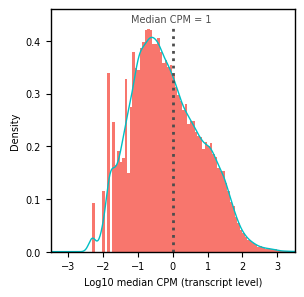

In [46]:
## Create log plot

log_median_cpm.plot(kind = "hist", density = True, bins = 100, color=ggplot2_colors[0], alpha=1) # change density to true, because KDE uses density


log_median_cpm.plot(kind = "kde", color=ggplot2_colors[4], alpha=1, linewidth=1)


plt.xlabel("Log10 median CPM (transcript level)", size=7)
plt.ylim([0, 0.46])
plt.xlim([-3.5, 3.5])


plt.axvline(0, ymax=0.94, alpha=1, linestyle = ":", color="#4D4D4D", linewidth=2)
plt.text(x=-1.2, y=0.435, s="Median CPM = 1", alpha=1, color="#4D4D4D", size=7)


plt.savefig('../../figures/paper_figures/supplement/transcript_level_density_plot_log10_median_cpm.pdf',
            dpi=600, transparent=True, bbox_inches="tight")


plt.show()

# ERCC correlation plot

In [47]:
ercc_baseline = pd.read_csv("../../references/ercc_baseline.csv")

In [48]:
df_ercc = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

In [49]:
df_ercc = fix_column_names(df_ercc, is_gene=False)
df_ercc = calculate_cpm(df_ercc, is_gene=False)

In [50]:
df_ercc = df_ercc.loc[df_ercc["gene_id"].str.startswith("ERCC")].copy()

In [51]:
df_ercc = df_ercc.filter(regex="transc|gene|CPM").copy()

In [52]:
df_ercc_melt = pd.melt(df_ercc, value_vars=df_ercc.columns[2:],
                                         id_vars=['gene_id', "transcript_id"], var_name='sample', value_name='CPM')

In [53]:
df_ercc_melt = df_ercc_melt.merge(ercc_baseline, on="gene_id", how="inner")

In [54]:
list_ercc_cpm = []
list_samples = []

for col in df_ercc.columns[2:]:
    
    total_errc_CPM = df_ercc[col].copy().sum()
    
    list_ercc_cpm.append(total_errc_CPM)
    list_samples.append(col.split("ample_")[1].split("_CP")[0])

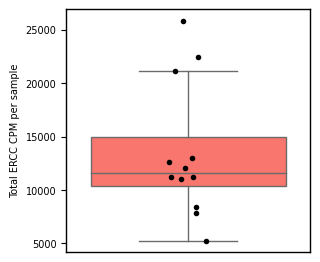

In [55]:
sns.boxplot(data=list_ercc_cpm, color=ggplot2_colors[0], saturation=1,
           showfliers=False, dodge=True, linewidth=1).set(xticklabels=[])


g = sns.stripplot(data=list_ercc_cpm, color="black", size=4, dodge=True)

plt.ylabel("Total ERCC CPM per sample")
plt.xlabel("")
plt.tick_params(bottom=False)

plt.savefig('../../figures/paper_figures/supplement/total_ercc_cpm.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

In [56]:
df_ercc_2 = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_ercc_2["mean"] = df_ercc_2[df_ercc_2.columns[2:]].sum(axis=1)


df_ercc_2 = fix_column_names(df_ercc_2, is_gene=False)
df_ercc_2.drop(columns=df_ercc_2.filter(regex="[0-9]_counts").columns, inplace=True)

df_ercc_2 = calculate_cpm(df_ercc_2, is_gene=False)
df_ercc_2.drop(columns="mean_counts", inplace=True)

df_ercc_2 = df_ercc_2.merge(ercc_baseline, on="gene_id", how="inner")

Spearman coefficient: 0.98
Spearman R-squared: 0.96
Spearman p-value: 4.726589615380758e-64

Pearson coefficient: 0.95
Pearson R-squared: 0.91
Pearson Slope: 0.12
Pearson Intercept: 16.84
Pearson P-value: 3.574852084939422e-49
Pearson Standard Error: 0.0038 



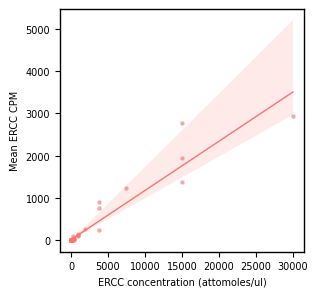

In [57]:
sns.regplot(data=df_ercc_2, x="concentration", y="mean_CPM", color=ggplot2_colors[0], 
           scatter_kws={"alpha": 0.5, "s":5}, line_kws={"linewidth": 1})

plt.ylabel("Mean ERCC CPM")
plt.xlabel("ERCC concentration (attomoles/ul)")

spearman_coeff, spearman_p = stats.spearmanr(df_ercc_2["concentration"].copy(),
                                                                     df_ercc_2["mean_CPM"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_ercc_2["concentration"].copy(),
                                                                     df_ercc_2["mean_CPM"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../figures/paper_figures/supplement/ercc_correlation_by_mean_cpm.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

## New ERCC transcript plots

In [58]:
## Import full length counts matrix

df = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/fullLengthCounts_transcript.txt", sep="\t")

In [59]:
## Fix columns names
df = fix_column_names(df, is_gene=False)

In [60]:
## Sum counts for each novel mito transcripts
df["total_counts"] = df[df.columns[2:]].sum(axis=1)

In [61]:
## Create filtered dataframes
df_ERCC = df.loc[((df["gene_id"] == "BambuGene290324") | (df["gene_id"] == "ERCC-00171"))].copy()

In [62]:
df_ERCC["gene_id"] = "ERCC-00171"

In [63]:
df_ERCC_counts_melt = pd.melt(df_ERCC, id_vars=['gene_id', 'transcript_id'],
                                          value_vars=df_ERCC.filter(regex="[0-9]_count").columns,
                                          value_name="count")

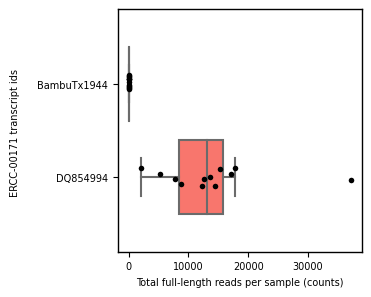

In [64]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.boxplot(data=df_ERCC_counts_melt, x="count", y="transcript_id",
            color=ggplot2_colors[0], saturation=1, showfliers=False)

sns.stripplot(data=df_ERCC_counts_melt,  y="transcript_id", x="count",
             color="black", size=4)

plt.ylabel("ERCC-00171 transcript ids \n")
plt.xlabel("Total full-length reads per sample (counts)")
ax.set_ylim(1.8, -0.8)

plt.savefig('../../figures/paper_figures/supplement/ERCC-00171_transcripts_full_counts.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

In [65]:
df_ERCC_filtered = df_ERCC_counts_melt.loc[df_ERCC_counts_melt["transcript_id"] == "BambuTx1944"]

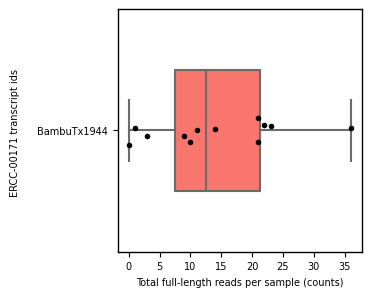

In [66]:
## Create and save graph showing number of genes with multiple protein coding isoforms (AVG CPM > 1)

ax = sns.boxplot(data=df_ERCC_filtered, x="count", y="transcript_id",
            color=ggplot2_colors[0], saturation=1, showfliers=False)

sns.stripplot(data=df_ERCC_filtered,  y="transcript_id", x="count",
             color="black", size=4)

plt.ylabel("ERCC-00171 transcript ids \n")
plt.xlabel("Total full-length reads per sample (counts)")
ax.set_ylim(0.8, -0.8)

plt.savefig('../../figures/paper_figures/supplement/ERCC-00171_ONLYNOVEL_transcripts_full_counts.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

## - Percent unique and full-length reads

In [67]:
## Import counts matrices

df = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_unique = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/uniqueCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_full = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/fullLengthCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

In [68]:
## Fix column names

df = fix_column_names(df, is_gene=False)
df_unique = fix_column_names(df_unique, is_gene=False)
df_full = fix_column_names(df_full, is_gene=False)

In [69]:
## Calculate CPM and drop count columns
df_cpm = calculate_cpm(df.copy(), is_gene=False)

df_cpm = df_cpm[df_cpm.columns.drop(list(df_cpm.filter(regex='counts')))].copy()

## Drop ERCCs
df_cpm = df_cpm.loc[~df_cpm["gene_id"].str.startswith("ERCC")].copy()

## Calculate median CPM
df_cpm["median_CPM"] = df_cpm[df_cpm.filter(regex='[0-9]_CPM').columns].median(axis=1)


## Find transcript_ids for median_CPM > 1 transcripts
df_cpm = df_cpm.loc[df_cpm["median_CPM"] > 1].copy()

transcript_ids_cpm_1 = df_cpm["transcript_id"].copy()

In [70]:
## Only keep transcript ids for median CPM > 1

df = df.loc[df["transcript_id"].isin(transcript_ids_cpm_1)].copy()

df_unique = df_unique.loc[df_unique["transcript_id"].isin(transcript_ids_cpm_1)].copy()

df_full = df_full.loc[df_full["transcript_id"].isin(transcript_ids_cpm_1)].copy()

In [71]:
## Change column names for full and unique dataframes

count_columns = df.filter(regex='counts').columns
unique_counts_columns = df_unique.filter(regex='counts').columns
full_count_columns = df_full.filter(regex='counts').columns


unique_counts_columns = [s + "_UNIQUE" for s in unique_counts_columns]
full_counts_columns = [s + "_FULL" for s in full_count_columns]

unique_counts_columns.insert(0, "gene_id")
unique_counts_columns.insert(0, "transcript_id")

full_counts_columns.insert(0, "gene_id")
full_counts_columns.insert(0, "transcript_id")

df_unique.columns = unique_counts_columns
df_full.columns = full_counts_columns

In [72]:
## Calculate percent full and percent unique

for col in count_columns:
    
    col_unique = col + "_UNIQUE"
    col_full = col + "_FULL"
    
    percent_full = col + "_percent_unique"
    percent_unique = col + "_percent_unique"
    
    df_full[percent_full] = round((df_full[col_full]/df[col]) * 100, 2)
    df_unique[percent_unique] = round((df_unique[col_unique]/df[col]) * 100, 2)

In [73]:
## Make melted dataframe

df_full["average_percent_full"] = round(df_full[df_full.filter(like="_percent").columns].mean(axis=1), 2)

In [74]:
## Make melted dataframe

df_unique["average_percent_unique"] = round(df_unique[df_unique.filter(like="_percent").columns].mean(axis=1), 2)

In [75]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (170*mm, 80*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

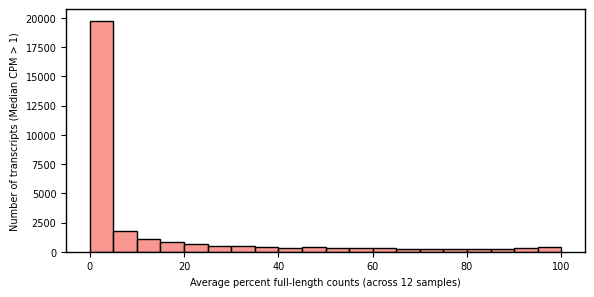

In [76]:
## Histplot for full-length percentage for each transcript with median CPM > 1

sns.histplot(df_full["average_percent_full"], bins=20, color=ggplot2_colors[0])

plt.xlabel("Average percent full-length counts (across 12 samples)")
plt.ylabel("Number of transcripts (Median CPM > 1)")

plt.savefig('../../figures/paper_figures/supplement/histogram_full_length.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

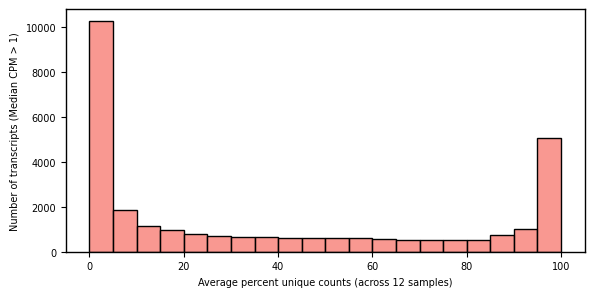

In [77]:
## Histplot for full-length percentage for each transcript with median CPM > 1

sns.histplot(df_unique["average_percent_unique"], bins=20, color=ggplot2_colors[0])

plt.xlabel("Average percent unique counts (across 12 samples)")
plt.ylabel("Number of transcripts (Median CPM > 1)")

plt.savefig('../../figures/paper_figures/supplement/histogram_unique.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

plt.show()

# XY plot of full length reads vs transcript length

In [78]:
## Import counts matrices

df = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/counts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_unique = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/uniqueCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

df_full = pd.read_csv("../../data/raw/nextflow_pipeline_output/bambu_discovery/fullLengthCounts_transcript.txt", 
                           delimiter="\t", low_memory=False, header=0)

In [79]:
## Fix column names

df = fix_column_names(df, is_gene=False)
df_unique = fix_column_names(df_unique, is_gene=False)
df_full = fix_column_names(df_full, is_gene=False)

In [80]:
## Calculate CPM and drop count columns
df_cpm = calculate_cpm(df.copy(), is_gene=False)

df_cpm = df_cpm[df_cpm.columns.drop(list(df_cpm.filter(regex='counts')))].copy()

## Drop ERCCs
df_cpm = df_cpm.loc[~df_cpm["gene_id"].str.startswith("ERCC")].copy()

## Calculate median CPM
df_cpm["median_CPM"] = df_cpm[df_cpm.filter(regex='[0-9]_CPM').columns].median(axis=1)


## Find transcript_ids for median_CPM > 1 transcripts
df_cpm = df_cpm.loc[df_cpm["median_CPM"] > 1].copy()

transcript_ids_cpm_1 = df_cpm["transcript_id"].copy()

In [81]:
## Only keep transcript ids for median CPM > 1

df = df.loc[df["transcript_id"].isin(transcript_ids_cpm_1)].copy()

df_unique = df_unique.loc[df_unique["transcript_id"].isin(transcript_ids_cpm_1)].copy()

df_full = df_full.loc[df_full["transcript_id"].isin(transcript_ids_cpm_1)].copy()

In [82]:
## Add real transcript length

df_with_length = df.merge(ref_transcript_length, on="transcript_id", how="inner")

In [83]:
## Calculate total counts

df_with_length["total_counts"] = df_with_length[df_with_length.filter(regex='counts').columns].sum(axis=1)

df_full["total_full_counts"] = df_full[df_full.filter(regex='counts').columns].sum(axis=1)

df_unique["total_unique_counts"] = df_unique[df_unique.filter(regex='counts').columns].sum(axis=1)

In [84]:
## Merge dataframe

df_merged_length = df_with_length[["transcript_id", "total_counts", "real_transcript_length"]].merge(
                        df_unique[["transcript_id", "total_unique_counts"]],
                        on="transcript_id", how="inner")

df_merged_length = df_merged_length.merge(
                        df_full[["transcript_id", "total_full_counts"]],
                        on="transcript_id", how="inner")

In [85]:
## Calculate percent unique and full length reads

df_merged_length["Percent full-length reads"] = ((df_merged_length["total_full_counts"]/df_merged_length["total_counts"]) * 100)

df_merged_length["Percent unique reads"] = ((df_merged_length["total_unique_counts"]/df_merged_length["total_counts"]) * 100)

In [86]:
## Calculate log10 transcript length

df_merged_length["Log10 transcript length"] =  np.log10(df_merged_length["real_transcript_length"].copy())

In [87]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (85*mm, 85*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

Spearman coefficient: -0.59
Spearman R-squared: 0.35
Spearman p-value: 0.0

Pearson coefficient: -0.52
Pearson R-squared: 0.27
Pearson Slope: -0.01
Pearson Intercept: 3.53
Pearson P-value: 0.0
Pearson Standard Error: 0.0001 



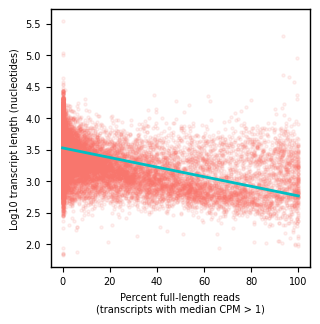

In [88]:
sns.regplot(data=df_merged_length, x="Percent full-length reads", 
            y="Log10 transcript length", scatter_kws={"color": ggplot2_colors[0], "alpha": 0.1, "s": 5},
            line_kws={"color": ggplot2_colors[4], "alpha": 1, "linewidth":2})

plt.ylabel("Log10 transcript length (nucleotides)")
plt.xlabel("Percent full-length reads\n(transcripts with median CPM > 1)")

spearman_coeff, spearman_p = stats.spearmanr(df_merged_length["Percent full-length reads"].copy(),
                                                                     df_merged_length["Log10 transcript length"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_merged_length["Percent full-length reads"].copy(),
                                                                     df_merged_length["Log10 transcript length"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")

plt.savefig('../../figures/paper_figures/supplement/transcript_length_vs_full_length.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

Spearman coefficient: -0.16
Spearman R-squared: 0.02
Spearman p-value: 8.578456378503441e-157

Pearson coefficient: -0.16
Pearson R-squared: 0.02
Pearson Slope: -0.0
Pearson Intercept: 3.49
Pearson P-value: 7.137889919078717e-156
Pearson Standard Error: 0.0001 



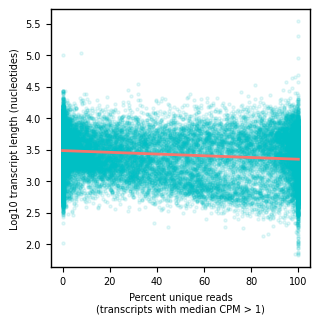

In [89]:
sns.regplot(data=df_merged_length, x="Percent unique reads", 
            y="Log10 transcript length", scatter_kws={"color": ggplot2_colors[4], "alpha": 0.1, "s":5},
            line_kws={"color": ggplot2_colors[0], "alpha": 1, "linewidth":2})


plt.ylabel("Log10 transcript length (nucleotides)")
plt.xlabel("Percent unique reads\n(transcripts with median CPM > 1)")

spearman_coeff, spearman_p = stats.spearmanr(df_merged_length["Percent unique reads"].copy(),
                                                                     df_merged_length["Log10 transcript length"].copy())

slope, intercept, r_value, p_value, std_err = stats.linregress(df_merged_length["Percent unique reads"].copy(),
                                                                     df_merged_length["Log10 transcript length"].copy())

print("Spearman coefficient:", str(round(spearman_coeff, 2)))
print("Spearman R-squared:", str(round((spearman_coeff * spearman_coeff), 2)))
print("Spearman p-value:", str(spearman_p))

print("\nPearson coefficient:", str(round(r_value, 2)))
print("Pearson R-squared:", str(round(r_value*r_value,2)))
print("Pearson Slope:", str(round(slope,2)))
print("Pearson Intercept:", str(round(intercept,2)))
print("Pearson P-value:", str(p_value))
print("Pearson Standard Error:", str(round(std_err,4)), "\n")


plt.savefig('../../figures/paper_figures/supplement/transcript_length_vs_unique.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

## - Percent unique reads vs number of annotated transcripts

In [90]:
## Create reference copy
ref2 = ref[["gene_id", "transcript_id"]].copy()

In [91]:
## Count number of transcripts per gene_id
num_transcripts = ref2["gene_id"].value_counts().reset_index()
num_transcripts.columns = ['gene_id', 'number_of_annotated_transcripts']

In [92]:
## Make it so it only goes to 6+

num_transcripts.loc[num_transcripts["number_of_annotated_transcripts"] >= 10, "number_of_annotated_transcripts"] = "≥10"

## Convert column to string
num_transcripts["number_of_annotated_transcripts"] = num_transcripts["number_of_annotated_transcripts"].astype(str)

In [93]:
## Merge to add gene_id and number of annotated transcripts

df_merged_length = df_merged_length.merge(ref[["gene_id", "transcript_id"]], how="inner", on="transcript_id")

df_merged_length = df_merged_length.merge(num_transcripts, how="inner", on="gene_id")

In [94]:
## Set parameters for figures
from matplotlib import rcParams
mm = (1/25.4)


# figure size in inches
rcParams['figure.figsize'] = (85*mm, 85*mm)
rcParams.update({'font.size': 7})
rcParams['axes.linewidth'] = 1

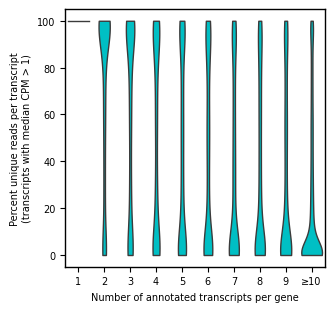

In [97]:
violin = sns.violinplot(data=df_merged_length, y="Percent unique reads", x="number_of_annotated_transcripts",
           saturation=1, color=ggplot2_colors[4],  inner=None, cut=0,
           showfliers=False, dodge=False, linewidth=1,
           order=["1", "2", "3", "4", "5", "6", "7", "8", "9", "≥10"])

plt.xlabel("Number of annotated transcripts per gene")
plt.ylabel("Percent unique reads per transcript\n(transcripts with median CPM > 1)")

plt.savefig('../../figures/paper_figures/supplement/number_of_annotated_transcripts_vs_unique_reads.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

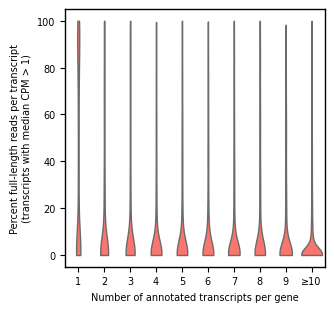

In [98]:
violin = sns.violinplot(data=df_merged_length, y="Percent full-length reads", x="number_of_annotated_transcripts",
           saturation=1, color=ggplot2_colors[0],  inner=None,
           showfliers=False, dodge=False, linewidth=1,
           order=["1", "2", "3", "4", "5", "6", "7", "8", "9", "≥10"], cut=0)


plt.xlabel("Number of annotated transcripts per gene")
plt.ylabel("Percent full-length reads per transcript\n(transcripts with median CPM > 1)")

plt.savefig('../../figures/paper_figures/supplement/number_of_annotated_transcripts_vs_full_reads.pdf',
            dpi=600, transparent=True, bbox_inches="tight")

In [2]:
#violin = sns.violinplot(data=df_merged_length, y="Percent unique reads", x="number_of_annotated_transcripts",
#           saturation=1, color=ggplot2_colors[4],  inner=None, cut=0,
#           showfliers=False, dodge=False, linewidth=1,
#           order=["1", "2", "3", "4", "5", "6", "7", "8", "9", "≥10"])

# Add larger median markers
#sns.pointplot(x=df_merged_length["number_of_annotated_transcripts"], y=df_merged_length["Percent unique reads"],
#              ax=violin, estimator=np.median, color='black', scale=0.5, errorbar=None,
#             order=["1", "2", "3", "4", "5", "6", "7", "8", "9", "≥10"])

#plt.xlabel("Number of annotated transcripts per gene")
#plt.ylabel("Percent unique reads\n(transcripts with median CPM > 1)")

#plt.savefig('../../figures/paper_figures/supplement/number_of_annotated_transcripts_vs_unique_reads.pdf',
#            dpi=600, transparent=True, bbox_inches="tight")

In [3]:
#violin = sns.violinplot(data=df_merged_length, y="Percent full-length reads", x="number_of_annotated_transcripts",
#           saturation=1, color=ggplot2_colors[0],  inner=None,
#           showfliers=False, dodge=False, linewidth=1,
#           order=["1", "2", "3", "4", "5", "6", "7", "8", "9", "≥10"], cut=0)

# Add larger median markers
#sns.pointplot(x=df_merged_length["number_of_annotated_transcripts"], y=df_merged_length["Percent full-length reads"],
#              ax=violin, estimator=np.median, color='black', scale=0.5, errorbar=None,
#             order=["1", "2", "3", "4", "5", "6", "7", "8", "9", "≥10"])


#plt.xlabel("Number of annotated transcripts per gene")
#plt.ylabel("Percent full-length reads\n(transcripts with median CPM > 1)")

#plt.savefig('../../figures/paper_figures/supplement/number_of_annotated_transcripts_vs_full_reads.pdf',
#            dpi=600, transparent=True, bbox_inches="tight")